In [1]:
import pandas as pd
import numpy as np

from src.util.FunctionExecTime import time_runtime

# Prepare the data

This competition is not intended to be a forecasting problem.
The prediction to be made is about how many of given items are
sold in a given shop.
The test set contains 5100 items and 42 shops. Thus, the total entries
to be predicted sums up to 5100 * 42 = 214'200 predictions.
Not very suiting for ARIMA.

Therefore, we have to modify the train data a little bit.
First, we are going to throw away all data from shops and items that are
present in the train data, but not in the test data.
Then, we are going to regroup the total sales of single items on a given day.
Finally, the shop information is thrown away. With ARIMA being a univariate
forecasting method, the item price is irrelevant as well.


In [2]:
# set to `True` if the data needs to be generated first
prepare_data = False

## Clean irrelevant data

This took about half an hour to run.

In [3]:
def clean_data():
    train = pd.read_csv('data/technical/sales_train.csv')
    test = pd.read_csv('data/technical/test.csv')

    # begin by preparing data

    # begin by clipping as the competition states
    train['item_cnt_day'] = train['item_cnt_day'].clip(0, 20)

    # first, throw away the data from irrelevant shops

    shops_in_test_set = set()
    for index, row in test.iterrows():
        shops_in_test_set.add(row['shop_id'])

    all_shops = set([*range(0, 60)])
    shops_missing = all_shops - shops_in_test_set

    for shop_missing in shops_missing:
        index_names = train[ train['shop_id'] == shop_missing].index
        train.drop(index_names, inplace=True)

    # throw away the data from irrelevant items

    items_in_test_set = set()
    for index, row in test.iterrows():
        items_in_test_set.add(row['item_id'])

    items_in_train_set = set()
    for index,row in train.iterrows():
        items_in_train_set.add(row['item_id'])

    items_missing = items_in_train_set - items_in_test_set

    for item_missing in items_missing:
        train.drop(train[train['item_id'] == item_missing].index, inplace=True)

    # remove the month sales as we are not going to account for this in the ARIMA forecast
    train.drop(['date_block_num', 'shop_id', 'item_price'], axis=1, inplace=True)

    # export items
    train.to_csv('data/arima/train_cleaned.csv', index=False)

if prepare_data:
    time_runtime(clean_data)

Runtime of function "clean_data": 30min & 35s


## Select item to be forecasted

We are now going to determine the most prominent item in the dataset.
Thankfully, this is a lot quicker. Takes about half a minute.

In [4]:
def select_item_for_forecast():
    train = pd.read_csv('data/arima/train_cleaned.csv')

    # to check for errors: print amount of dates in total available in the dataset
    all_dates = set()
    for index, row in train.iterrows():
        all_dates.add(row['date'])
    len(all_dates)


    train = train.groupby(['date', 'item_id']).sum('item_cnt_day').reset_index()

    all_items = set()
    for index,row in train.iterrows():
        all_items.add(row['item_id'])

    date_sequences_all_items = []

    for item in all_items:

        df_this_item = train[train.item_id == item]

        date_sequences_all_items.append(
            (item, df_this_item)
        )

    for sequence in date_sequences_all_items:
        if sequence[1].shape[0] > 1000:
            print(f"Item ID: {sequence[0]}\nData present for {sequence[1].shape[0]} days.")

    # allocate a new df to the most prominent item
    df = train[train.item_id == 5822].copy()
    df.drop('item_id', axis=1, inplace=True)

    # insert zero-sales for the days that are missing in the item series.
    all_dates_in_dataset = set()
    for _, row in df.iterrows():
        all_dates_in_dataset.add(row['date'])

    # dates without sales are: 06.02.20112 & 11.02.2013
    dates_in_dataset_missing = all_dates - all_dates_in_dataset

    for date in dates_in_dataset_missing:
        new_row = pd.DataFrame({'date': [date], 'item_cnt_day': [0.0]})
        df = df.append(new_row)

    # format the table
    df['date'] = pd.to_datetime(df['date'], dayfirst=True).dt.date
    df.sort_values(by='date', inplace=True)
    df.set_index('date', drop=True, inplace=True)

    df.to_csv('data/arima/inspect_this_item.csv')

if prepare_data:
    time_runtime(select_item_for_forecast)

Item ID: 2308
Data present for 1014 days.
Item ID: 5822
Data present for 1032 days.
Runtime of function "select_item_for_forecast": 41s


# Forecast

## Preparation

In [5]:
df = pd.read_csv('data/arima/inspect_this_item.csv')
# convert the date back to datetime object and set a DatetimeIndex
df['date'] = pd.to_datetime(df['date'], dayfirst=True).dt.date
df.set_index('date', drop=True, inplace=True)
df.index = pd.DatetimeIndex(df.index).to_period('d')

# assign the correct datatype and rename the column
df['item_cnt_day'] = df['item_cnt_day'].astype(np.int16)
df.rename(columns={'item_cnt_day': 'sales'}, inplace=True)

In [6]:
# evaluate the score analog to the linear regression model
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_prediction):
    return np.sqrt(mean_squared_error(y_test, y_prediction))

In [7]:
# set matplotlib defaults
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (30,10)

## Analyze timeseries

To start off, get a feel for the distribution of the sales data.

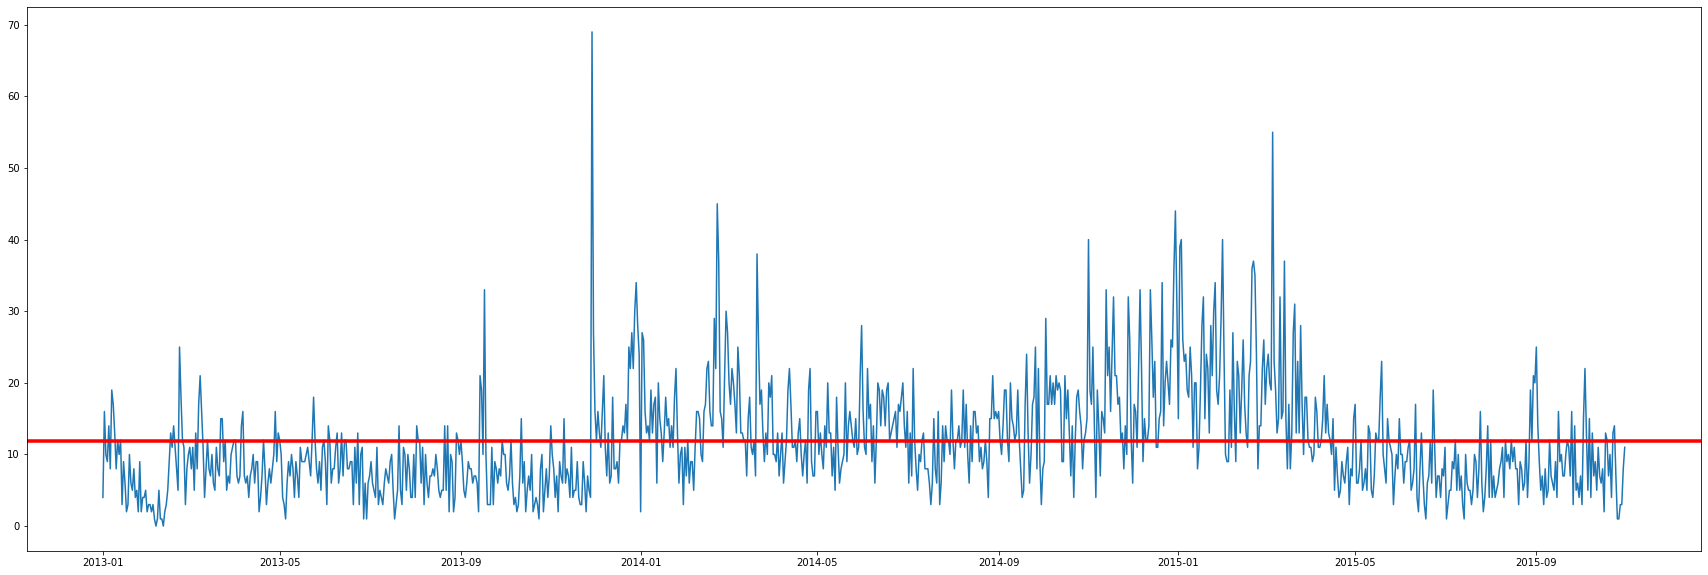

In [8]:
# plot the time series
plt.plot_date(df.index, df['sales'], fmt="", marker=None)
mean = df['sales'].mean()
plt.axhline(mean, color='red', linewidth=3.5)

## A first primitive ARIMA application

Apply the ARIMA model without much thought.
Let's find out how much more we can improve this by
analyzing the optimal parameters.

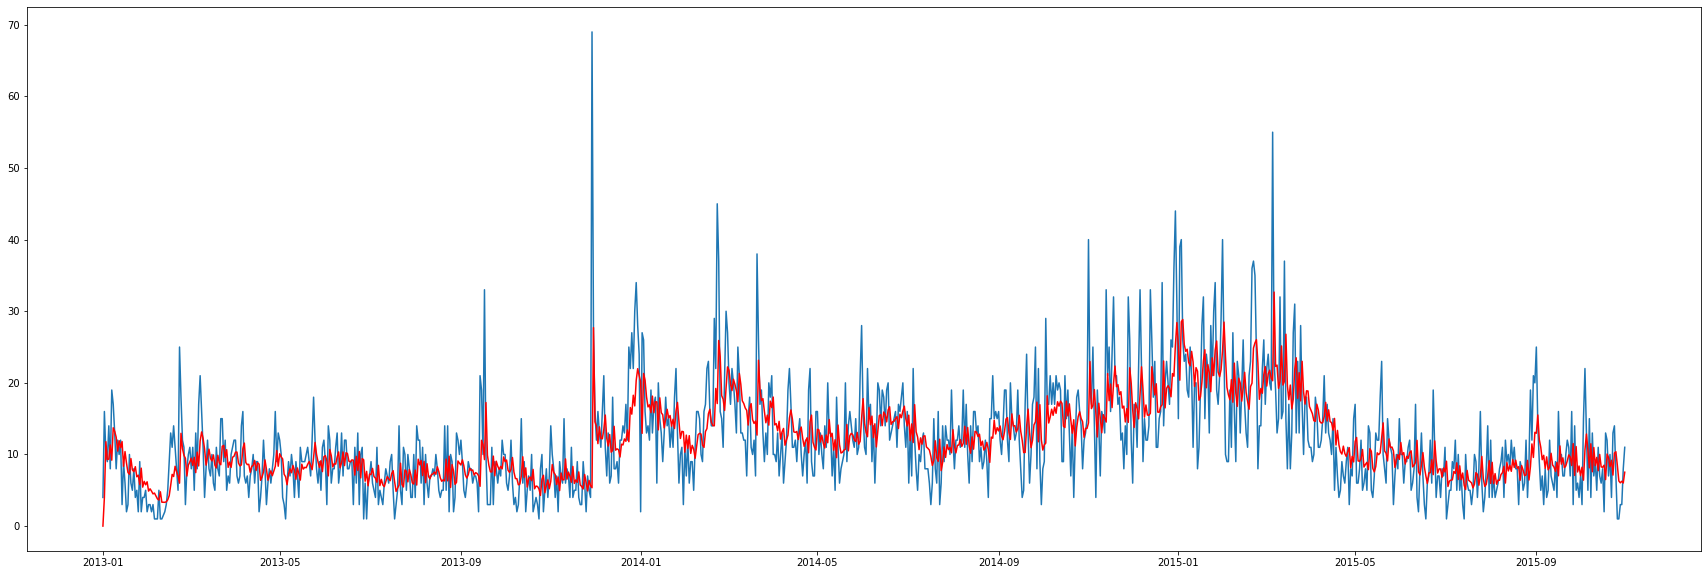

In [9]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df, order=(2,1,2))
results_ARIMA = model.fit()
plt.plot_date(df.index, df['sales'], fmt="", marker=None)
plt.plot(results_ARIMA.fittedvalues, color='red')

In [10]:
# inspect the RMSE analog to the linear regression data
rmse(df['sales'], results_ARIMA.fittedvalues)

5.855317761127395